In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.2'
spark_version = 'spark-<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("bigfoot").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.0/22/bigfoot.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("bigfoot.csv"), header=True, inferSchema=True)

# Show DataFrame
df.show()

+------+--------------------+--------------+--------------------+
|number|               title|classification|           timestamp|
+------+--------------------+--------------+--------------------+
|   637|Report 637: Campe...|       Class A|2000-06-16T12:00:00Z|
|  2917|Report 2917: Fami...|       Class A|1995-05-15T12:00:00Z|
|  7963|Report 7963: Sasq...|       Class A|2004-02-09T12:00:00Z|
|  9317|Report 9317: Driv...|       Class A|2004-06-18T12:00:00Z|
| 13038|Report 13038: Sno...|       Class A|2004-02-15T12:00:00Z|
| 23666|Report 23666: Pas...|       Class A|2008-04-23T12:00:00Z|
| 26604|Report 26604: Day...|       Class A|2009-07-15T12:00:00Z|
|   179|Report 179: Man a...|       Class A|1981-09-15T12:00:00Z|
|   245|Report 245: Two o...|       Class A|1999-07-15T12:00:00Z|
|   416|Report 416: A res...|       Class A|1983-11-15T12:00:00Z|
|   435|Report 435: Dayli...|       Class A|2000-10-10T12:00:00Z|
|   451|Report 451: Young...|       Class A|1993-08-20T12:00:00Z|
|   577|Re

In [5]:
from pyspark.sql.types import TimestampType
df = df.withColumn("timestamp", df["timestamp"].cast(TimestampType()))

In [6]:
df.printSchema()

root
 |-- number: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- classification: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [7]:
# Import date time functions
from pyspark.sql.functions import month, year

In [8]:
# Create a new DataFrame with the column Year
df.select(year(df["timestamp"])).show()

+---------------+
|year(timestamp)|
+---------------+
|           2000|
|           1995|
|           2004|
|           2004|
|           2004|
|           2008|
|           2009|
|           1981|
|           1999|
|           1983|
|           2000|
|           1993|
|           1999|
|           1978|
|           1980|
|           1997|
|           1990|
|           1996|
|           2000|
|           2001|
+---------------+
only showing top 20 rows



In [9]:
# Save the year as a new column
df = df.withColumn("year", year(df['timestamp']))
df.show()

+------+--------------------+--------------+-------------------+----+
|number|               title|classification|          timestamp|year|
+------+--------------------+--------------+-------------------+----+
|   637|Report 637: Campe...|       Class A|2000-06-16 12:00:00|2000|
|  2917|Report 2917: Fami...|       Class A|1995-05-15 12:00:00|1995|
|  7963|Report 7963: Sasq...|       Class A|2004-02-09 12:00:00|2004|
|  9317|Report 9317: Driv...|       Class A|2004-06-18 12:00:00|2004|
| 13038|Report 13038: Sno...|       Class A|2004-02-15 12:00:00|2004|
| 23666|Report 23666: Pas...|       Class A|2008-04-23 12:00:00|2008|
| 26604|Report 26604: Day...|       Class A|2009-07-15 12:00:00|2009|
|   179|Report 179: Man a...|       Class A|1981-09-15 12:00:00|1981|
|   245|Report 245: Two o...|       Class A|1999-07-15 12:00:00|1999|
|   416|Report 416: A res...|       Class A|1983-11-15 12:00:00|1983|
|   435|Report 435: Dayli...|       Class A|2000-10-10 12:00:00|2000|
|   451|Report 451: 

In [10]:
# Find the total bigfoot sightings per year
averages = df.groupBy("year").count()
averages.orderBy("year").select("year", "count").show()

+----+-----+
|year|count|
+----+-----+
|null|    6|
|1869|    1|
|1921|    1|
|1925|    1|
|1930|    1|
|1932|    1|
|1934|    1|
|1937|    1|
|1938|    1|
|1941|    1|
|1942|    1|
|1944|    2|
|1947|    1|
|1948|    1|
|1949|    2|
|1950|    3|
|1952|    1|
|1953|    2|
|1954|    1|
|1955|    3|
+----+-----+
only showing top 20 rows



In [11]:
# Import the summarized data to a pandas DataFrame for plotting
# Note: If your summarized data is still too big for your local memory then your notebook may crash
import pandas as pd
pandas_df = averages.orderBy("year").select("year", "count").toPandas()
pandas_df.head()

,year,count
0,NaN,6
1,1869.0,1
2,1921.0,1
3,1925.0,1
4,1930.0,1


In [12]:
# Clean the data and rename the columns to "year" and "sightings"
pandas_df = pandas_df.dropna()
pandas_df = pandas_df.rename(columns={"count": "sightings"})
pandas_df.head()

,year,sightings
1,1869.0,1
2,1921.0,1
3,1925.0,1
4,1930.0,1
5,1932.0,1


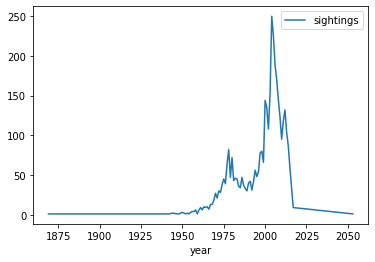

In [13]:
# Plot the year and sightings
%matplotlib inline
pandas_df.plot("year", "sightings")